In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Citroen.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.drop(df2[(df2["Fiyat"] > 1000000)].index, axis=0, inplace=True)

In [5]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_AX,Seri_C-Elysee,Seri_C1,...,Model_Picasso 1.6 HDi Exclusive,Model_Picasso 1.6 SX,Model_Picasso 1.8 Exclusive,Model_Picasso 2.0 HDi,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,436500,2017,93,1560,130000,NaN,NaN,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,240000,2011,71,1398,250000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,275000,2011,71,1398,177000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,218000,2007,71,1398,288000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,516990,2012,114,1560,223000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [6]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [8]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [9]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [10]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_9420\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,45674.324207,1.455239e+09,38147.596701,27968.390825


In [11]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [12]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:08:55,373] A new study created in memory with name: no-name-ed2b3088-337f-4535-97c1-7c98937d42c8
[I 2023-10-08 14:08:55,617] Trial 1 finished with value: 382400.56703674205 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.005182076627178477, 'max_depth': 3, 'min_child_weight': 289}. Best is trial 1 with value: 382400.56703674205.
[I 2023-10-08 14:08:55,617] Trial 2 finished with value: 398286.9867160503 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.0006844995357755976, 'max_depth': 15, 'min_child_weight': 165}. Best is trial 1 with value: 382400.56703674205.
[I 2023-10-08 14:08:55,633] Trial 0 finished with value: 187474.65048230617 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.07695125885085757, 'max_depth': 6, 'min_child_weight': 111}. Best is trial 0 with value: 187474.65048230617.
[I 2023-10-08 14:08:55,692] Trial 5 finished with value: 90459.16155158375 and parameters: 

[I 2023-10-08 14:08:57,147] Trial 31 finished with value: 226093.4423319522 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.05832383925695888, 'max_depth': 14, 'min_child_weight': 75}. Best is trial 23 with value: 43324.42393002182.
[I 2023-10-08 14:08:57,157] Trial 30 finished with value: 208751.35970129495 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.06625162733244123, 'max_depth': 12, 'min_child_weight': 61}. Best is trial 23 with value: 43324.42393002182.
[I 2023-10-08 14:08:57,278] Trial 33 finished with value: 170590.24267871032 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.08646747111825202, 'max_depth': 10, 'min_child_weight': 60}. Best is trial 23 with value: 43324.42393002182.
[I 2023-10-08 14:08:57,325] Trial 32 finished with value: 219675.05189866247 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.06123709872562237, 'max_depth': 10, 'min_child_wei

[I 2023-10-08 14:08:59,627] Trial 60 finished with value: 83974.17454209135 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.16118106128727192, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 23 with value: 43324.42393002182.
[I 2023-10-08 14:08:59,644] Trial 61 finished with value: 87260.90861119023 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.1573698247122519, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 23 with value: 43324.42393002182.
[I 2023-10-08 14:08:59,681] Trial 62 finished with value: 84659.12967395631 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.16275723037221865, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 23 with value: 43324.42393002182.
[I 2023-10-08 14:08:59,709] Trial 63 finished with value: 82011.9846193447 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.16572610310310695, 'max_depth': 4, 'min_child_weight': 3}. B

[I 2023-10-08 14:09:02,097] Trial 90 finished with value: 42952.06522876089 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.4990953573535227, 'max_depth': 8, 'min_child_weight': 12}. Best is trial 74 with value: 39818.062673428394.
[I 2023-10-08 14:09:02,113] Trial 91 finished with value: 41697.03171834953 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.4806268268716284, 'max_depth': 8, 'min_child_weight': 12}. Best is trial 74 with value: 39818.062673428394.
[I 2023-10-08 14:09:02,509] Trial 92 finished with value: 48395.60005860177 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.4837987680297807, 'max_depth': 9, 'min_child_weight': 86}. Best is trial 74 with value: 39818.062673428394.
[I 2023-10-08 14:09:02,580] Trial 93 finished with value: 42803.72793212032 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.4272222346166923, 'max_depth': 9, 'min_child_weight': 42

[I 2023-10-08 14:09:05,645] Trial 120 finished with value: 43313.71732973326 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.4076461404314493, 'max_depth': 11, 'min_child_weight': 1}. Best is trial 74 with value: 39818.062673428394.
[I 2023-10-08 14:09:05,733] Trial 123 finished with value: 41831.41133794027 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.4026070248635723, 'max_depth': 6, 'min_child_weight': 1}. Best is trial 74 with value: 39818.062673428394.
[I 2023-10-08 14:09:05,741] Trial 121 finished with value: 40471.27351543151 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.4054266494934201, 'max_depth': 6, 'min_child_weight': 7}. Best is trial 74 with value: 39818.062673428394.
[I 2023-10-08 14:09:05,829] Trial 122 finished with value: 41784.777768897795 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.4080121532651725, 'max_depth': 6, 'min_child_weight':

[I 2023-10-08 14:09:09,249] Trial 148 finished with value: 121830.36138150588 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.12246371116056914, 'max_depth': 6, 'min_child_weight': 24}. Best is trial 74 with value: 39818.062673428394.
[I 2023-10-08 14:09:09,281] Trial 151 finished with value: 41109.51626693588 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.3182966302452415, 'max_depth': 6, 'min_child_weight': 6}. Best is trial 74 with value: 39818.062673428394.
[I 2023-10-08 14:09:09,281] Trial 153 finished with value: 350360.5633193658 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.013914453337128792, 'max_depth': 6, 'min_child_weight': 21}. Best is trial 74 with value: 39818.062673428394.
[I 2023-10-08 14:09:09,409] Trial 150 finished with value: 330335.09767137206 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.019965864880603777, 'max_depth': 6, 'min_child_w

[I 2023-10-08 14:09:12,908] Trial 182 finished with value: 42491.361493913246 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.4984866616155476, 'max_depth': 7, 'min_child_weight': 18}. Best is trial 158 with value: 39805.67544307167.
[I 2023-10-08 14:09:12,969] Trial 178 finished with value: 44260.09335669096 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.2840448112262219, 'max_depth': 7, 'min_child_weight': 17}. Best is trial 158 with value: 39805.67544307167.
[I 2023-10-08 14:09:13,043] Trial 181 finished with value: 41393.94790021855 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.4794242195598878, 'max_depth': 7, 'min_child_weight': 17}. Best is trial 158 with value: 39805.67544307167.
[I 2023-10-08 14:09:13,095] Trial 183 finished with value: 42145.71006190328 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.4869502425176761, 'max_depth': 7, 'min_child_weight

[I 2023-10-08 14:09:16,147] Trial 210 finished with value: 39893.38506511962 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.41815667554809255, 'max_depth': 7, 'min_child_weight': 16}. Best is trial 200 with value: 38173.53268157702.
[I 2023-10-08 14:09:16,225] Trial 212 finished with value: 41571.50828860312 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.4151721159782696, 'max_depth': 5, 'min_child_weight': 17}. Best is trial 200 with value: 38173.53268157702.
[I 2023-10-08 14:09:16,258] Trial 211 finished with value: 40950.08394068041 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.40900333076878265, 'max_depth': 5, 'min_child_weight': 17}. Best is trial 200 with value: 38173.53268157702.
[I 2023-10-08 14:09:16,410] Trial 213 finished with value: 40258.1788832713 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.4246582939975621, 'max_depth': 6, 'min_child_weight

[I 2023-10-08 14:09:19,339] Trial 240 finished with value: 40906.36476433188 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.3228962382363625, 'max_depth': 6, 'min_child_weight': 19}. Best is trial 200 with value: 38173.53268157702.
[I 2023-10-08 14:09:19,594] Trial 243 finished with value: 42084.913905958834 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.30421047470098, 'max_depth': 6, 'min_child_weight': 11}. Best is trial 200 with value: 38173.53268157702.
[I 2023-10-08 14:09:19,610] Trial 241 finished with value: 40706.140221668196 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.32182682808369256, 'max_depth': 6, 'min_child_weight': 11}. Best is trial 200 with value: 38173.53268157702.
[I 2023-10-08 14:09:19,704] Trial 242 finished with value: 73231.3142743615 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.1752731701564451, 'max_depth': 6, 'min_child_weight'

In [13]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 38173.5327
Best params:
	colsample_bytree: 0.3
	subsample: 0.8
	learning_rate: 0.39666632633567833
	max_depth: 6
	min_child_weight: 10


In [14]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 45302.8294978596, 'MSE': 1485632390.131163, 'RMSE': 38543.902113449316, 'MAE': 28517.2129364339}


In [15]:
r2 = r2_score(y_test, y_pred)
r2

0.9088504896987556

In [16]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.8956791468489422

In [17]:
marka_model = joblib.dump(final_model, "Citroen.pkl")

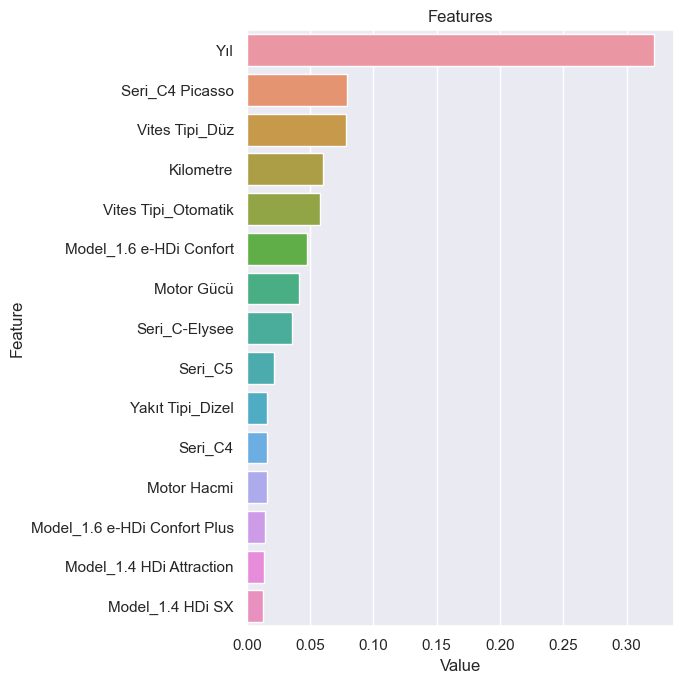

In [18]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)

In [19]:
y_test2 = list(y_test)

In [20]:
df3 = pd.DataFrame(list(zip(y_test, y_pred,(y_pred-y_test))),
               columns =['test', 'pred',"fark"])

In [21]:
df3

,test,pred,fark
0,295000,297881.37500,2881.37500
1,310000,304963.46875,-5036.53125
2,295000,285737.15625,-9262.84375
3,480000,469173.68750,-10826.31250
4,458000,467897.00000,9897.00000
...,...,...,...
464,350000,338848.75000,-11151.25000
465,295000,276084.56250,-18915.43750
466,257000,287886.12500,30886.12500
467,450000,353440.46875,-96559.53125


In [22]:
df3.describe([0.05,0.25, 0.75,0.90,0.99]).T

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max
test,469.0,380040.168443,127803.281402,80000.000000,165000.000000,285555.00000,395000.00000,460000.00000,546800.0000,719440.0000,775000.00000
pred,469.0,380042.750000,123913.070312,98604.757812,166776.965625,287110.03125,388121.59375,458413.59375,534384.1875,700019.3725,781829.25000
fark,469.0,2.553555,38585.059437,-163211.906250,-65932.956250,-19827.81250,334.96875,24145.34375,41421.5500,90717.8500,214941.28125


In [23]:
df3["test"].max()

775000

In [24]:
df3[df3["test"]==4350000]

,test,pred,fark


In [25]:
df3[df3["test"] > 1000000]

,test,pred,fark


In [26]:
y_train2 = list(y_train)

In [27]:
for i in y_train2:
    if i > 1000000:
        print(i)